<a href="https://colab.research.google.com/github/puigruizjosep1/RL_implementations/blob/main/MonteCarlo_Policy_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Implementing First-Visit Monte-Carlo Evaluation, from Sutton's book
# http://www.incompleteideas.net/book/RLbook2020.pdf, page 99; Example 5.3. 

import random
__single_deck = sorted([value for value in range(2, 12) for _ in range(4)] + [10]*12)

def codify_state(player_current_sum, up_card_dealer, usable_ace):
    return '{}_{}_{}'.format(str(int(player_current_sum)), str(up_card_dealer), str(usable_ace))


def get_count_and_usable_ace(lst_cards_original):
    lst_cards = [c for c in lst_cards_original]
    sum_11 = sum(lst_cards)
    if sum_11 <= 21:
        return sum_11, 11 in lst_cards, lst_cards
    # If count > 21:
    for i, card in enumerate(lst_cards):
        if card == 11:
            lst_cards[i]=1
            sum_11 -= 10
            if sum_11 <= 21:
                return sum_11, 11 in lst_cards, lst_cards
    return sum_11, 11 in lst_cards, lst_cards

def naive_policy(state):
    count = int(state.split('_')[0])
    return 'stick' if count > 19 else 'hit'


def simulate_BJ_episode():
    lst_SARS = []
    # 1st) Draw cards for player
    player_cards = [random.choice(__single_deck), random.choice(__single_deck)]
    player_count, usable_ace, player_cards = get_count_and_usable_ace(player_cards)
    while player_count < 12:
        player_cards.append(random.choice(__single_deck))
        player_count, usable_ace, player_cards = get_count_and_usable_ace(player_cards)
    # 2nd) Draw card for dealer
    dealer_card = random.choice(__single_deck) # To ensure no data leakage, sampling 2nd card later. Replacement, so it's not important
    dealer_cards = [dealer_card]
    current_state = codify_state(player_current_sum = player_count, up_card_dealer=dealer_card, usable_ace=usable_ace)
    
    episode_done = False
    

    while not episode_done:
        
        # Decide action per policy
        action = naive_policy(current_state)
        #print('State = {}, action={}'.format(current_state, action))
        if action == 'hit':
            #print('Action = HIT for player_cards = {}'.format(player_cards))
            player_cards.append(random.choice(__single_deck))
            player_count, usable_ace, player_cards = get_count_and_usable_ace(player_cards)
            new_state = codify_state(player_current_sum = player_count, up_card_dealer=dealer_card, usable_ace=usable_ace)
            if player_count > 21:
                episode_done = True
                reward = -1
                
            else:
                reward = 0



            # UPDATE STATE! current_state = new_state
        elif action == 'stick':
            #print('Action = STICK for player_cards = {}'.format(player_cards))
            episode_done = True
            # Simulate game for dealer
            
            new_state = 'NAN'
            dealer_done = False
            while not dealer_done:
                dealer_count, _, dealer_cards = get_count_and_usable_ace(dealer_cards)
                if dealer_count >= 17:
                    dealer_done = True
                else:
                    dealer_cards.append(random.choice(__single_deck))

            if dealer_count > 21:
                reward = 1
            else:
                reward = 1 if player_count > dealer_count else (0 if player_count == dealer_count else -1) 

        lst_SARS.append([current_state, action, reward, new_state, True, player_cards.copy(), dealer_cards]) 
        if not episode_done:
            current_state = new_state
    #print('Dealer cards = {}'.format(dealer_cards))
    return lst_SARS

In [7]:
## NON-OPTIMAL FIRST-VISIT MONTE-CARLO SCHEME for POLICY EVALUATION (optimized in next cell)

lst_states = [codify_state(a, b, c) for a in range(12, 22) for b in range(2, 12) for c in [True, False]]

V = {s: 0 for s in lst_states}

returns = {s: [] for s in lst_states}

end_condition = False
gamma = 1.0
count_episodes = 1
N_episodes = 500000
while not end_condition:
    # New episode
    episode = simulate_BJ_episode() # TODO save as tuples [S, A, R, S_next, first_visit] --> LIST OF LISTS
    # if count_episodes % 1000 == 0:
    #     print('Episode {}'.format(count_episodes))
    return_episode = 0

    count_episodes += 1
    if count_episodes > N_episodes:
        end_condition = True

    for S, A, R, S_next, first_visit, _, _ in episode[::-1]: # Backwards(!)
        
        return_episode = gamma*return_episode + R
        if first_visit:
            returns[S].append(return_episode)
            V[S] = sum(returns[S])/len(returns[S])



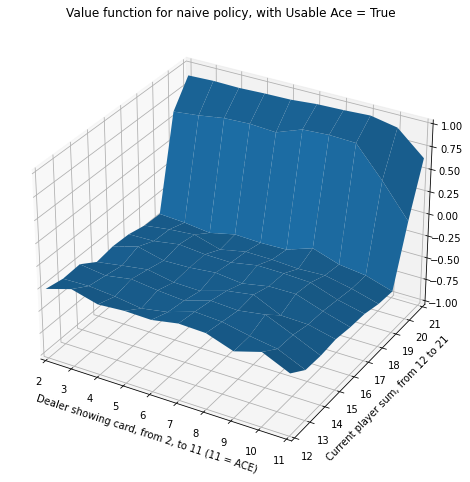

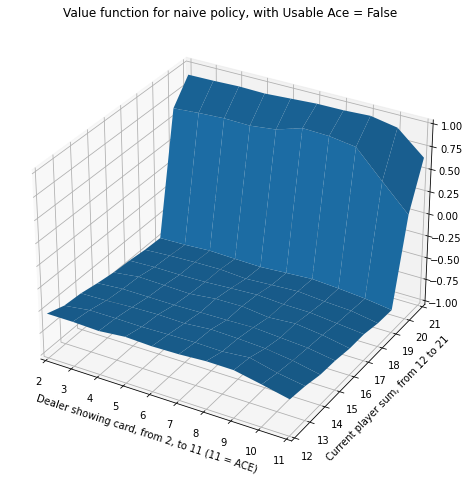

In [8]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

X = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11] #Dealer showing card
Y = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21] #Player sum
X_mesh,Y_mesh = np.meshgrid(X,Y)

for ACE in [True, False]:
    Z_mesh = np.array([[V[codify_state(y, x, ACE)] for x in X] for y in Y])



    fig = plt.figure(figsize=(8, 12))
    ax = fig.add_subplot(111, projection='3d')
    plt.xticks(X)
    plt.yticks(Y)
    ax.set_zlim([-1, +1])
    ax.set_ylim([12, 21])
    ax.set_xlim([2, 11])


    plt.ylabel('Current player sum, from 12 to 21')
    plt.xlabel('Dealer showing card, from 2, to 11 (11 = ACE)')
    plt.title('Value function for naive policy, with Usable Ace = {}'.format(ACE))
    ax.plot_surface(X_mesh, Y_mesh, Z_mesh)

    fig.show()


In [9]:
## OPTIMIZED FIRST-VISIT MONTE-CARLO SCHEME for POLICY EVALUATION

lst_states = [codify_state(a, b, c) for a in range(12, 22) for b in range(2, 12) for c in [True, False]]

V = {s: 0 for s in lst_states}

returns = {s: [0, 0] for s in lst_states} #1st element: sum, 2nd element: count

end_condition = False
gamma = 1.0
count_episodes = 1
N_episodes = 500000
while not end_condition:
    # New episode
    episode = simulate_BJ_episode() # TODO save as tuples [S, A, R, S_next, first_visit] --> LIST OF LISTS
    # if count_episodes % 1000 == 0:
    #     print('Episode {}'.format(count_episodes))
    return_episode = 0

    count_episodes += 1
    if count_episodes > N_episodes:
        end_condition = True

    for S, A, R, S_next, first_visit, _, _ in episode[::-1]: # Backwards(!)
        
        return_episode = gamma*return_episode + R
        if first_visit:
            returns[S][0]+=return_episode
            returns[S][1]+=1
            #returns[S].append(return_episode)
            V[S] = returns[S][0]/(returns[S][1])


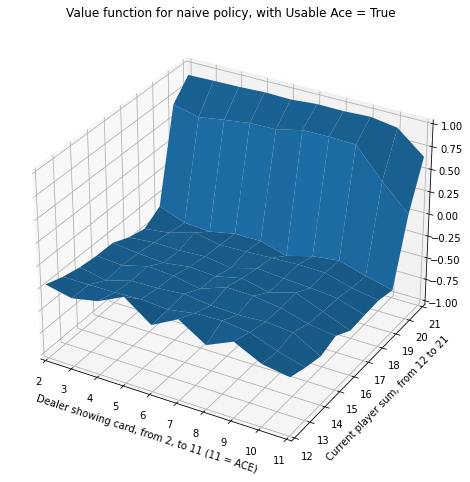

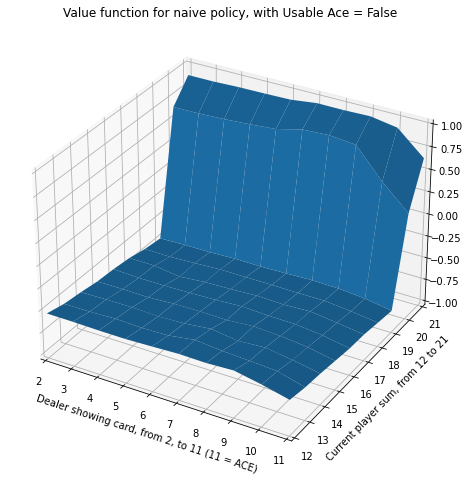

In [10]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

X = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11] #Dealer showing card
Y = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21] #Player sum
X_mesh,Y_mesh = np.meshgrid(X,Y)

for ACE in [True, False]:
    Z_mesh = np.array([[V[codify_state(y, x, ACE)] for x in X] for y in Y])



    fig = plt.figure(figsize=(8, 12))
    ax = fig.add_subplot(111, projection='3d')
    plt.xticks(X)
    plt.yticks(Y)
    ax.set_zlim([-1, +1])
    ax.set_ylim([12, 21])
    ax.set_xlim([2, 11])


    plt.ylabel('Current player sum, from 12 to 21')
    plt.xlabel('Dealer showing card, from 2, to 11 (11 = ACE)')
    plt.title('Value function for naive policy, with Usable Ace = {}'.format(ACE))
    ax.plot_surface(X_mesh, Y_mesh, Z_mesh)

    fig.show()
